In [5]:
# %load src/request_simulator.py
from collections import namedtuple
import random

import numpy as np
import simpy

LatencyDatum = namedtuple(
    'LatencyDatum',
    ('t_queued', 't_processing', 't_total')
)


class RequestSimulator(object):
    """ Simulates a M/G/k process common in request processing (computing)

    :param worker_desc: A tuple of (count, capacity) to construct workers with
    :param local_balancer: A function which takes the current request number
        and the list of workers and returns the index of the worker to send the
        next request to
    :param latency_fn: A function which takes the curent
        request number and the worker that was assigned by the load balancer
        amd returns the number of milliseconds a request took to process
    :param number_of_requests: The number of requests to run through the
        simulator
    :param request_per_s: The rate of requests per second.
    """
    def __init__(
            self, worker_desc, load_balancer, latency_fn,
            number_of_requests, request_per_s):
        self.worker_desc = worker_desc
        self.load_balancer = load_balancer
        self.latency_fn = latency_fn
        self.number_of_requests = int(number_of_requests)
        self.request_interval_ms = 1. / (request_per_s / 1000.)
        self.data = []

    def simulate(self):
        # Setup and start the simulation
        random.seed(1)
        np.random.seed(1)

        self.env = simpy.Environment()
        count, cap = self.worker_desc
        self.workers = [
            simpy.Resource(self.env, capacity=cap) for i in range(count)
        ]
        self.env.process(self.generate_requests())
        self.env.run()

    def generate_requests(self):
        for i in range(self.number_of_requests):
            idx = self.load_balancer(i, self.workers)
            worker = self.workers[idx]
            response = self.process_request(
                i, worker,
            )
            self.env.process(response)
            # Exponential inter-arrival times == Poisson
            arrival_interval = random.expovariate(
                1.0 / self.request_interval_ms
            )
            yield self.env.timeout(arrival_interval)

    def process_request(self, request_id, worker):
        """ Request arrives, possibly queues, and then processes"""
        t_arrive = self.env.now

        with worker.request() as req:
            yield req
            t_start = self.env.now
            t_queued = t_start - t_arrive

            # Let the operation take w.e. amount of time the latency
            # function tells us to
            yield self.env.timeout(self.latency_fn(request_id))

            t_done = self.env.now
            t_processing = t_done - t_start
            t_total_response = t_done - t_arrive

            datum = LatencyDatum(t_queued, t_processing, t_total_response)
            self.data.append(datum)


def run_simulation(
        worker_desc, load_balancer, num_requests, request_per_s, latency_fn):
    simulator = RequestSimulator(
        worker_desc, load_balancer, latency_fn,
        num_requests, request_per_s
    )
    simulator.simulate()
    return simulator.data


In [6]:
# %load src/speculation_simulator.py
from collections import namedtuple
import random

import numpy as np
import simpy

LatencyDatum = namedtuple(
    'LatencyDatum',
    ('t_queued', 't_processing', 't_total')
)


class SpeculatingRequestExecutor(object):
    """ Simulates a M/G/k process common in request processing (computing) but
    with always on speculation to another host

    :param worker_desc: A tuple of (count, capacity) to construct workers with
    :param local_balancer: A function which takes the current request number
        and the list of workers and returns the index of the worker to
        send the next request to
    :param latency_fn: A function which takes the curent request number and the
        worker that was assigned by the load balancer and returns the number of
        milliseconds a request took to process
    :param number_of_requests: The number of requests to run through the
        simulator
    :param request_per_s: The rate of requests per second.
    """
    def __init__(
            self, worker_desc, load_balancer, latency_fn,
            number_of_requests, request_per_s):
        self.worker_desc = worker_desc
        self.load_balancer = load_balancer
        self.latency_fn = latency_fn
        self.number_of_requests = int(number_of_requests)
        self.request_interval_ms = 1. / (request_per_s / 1000.)
        self.received_first = {'1': 0, '2': 0}
        self.data = []

    def simulate(self):
        # Setup and start the simulation
        random.seed(1)
        np.random.seed(1)

        self.env = simpy.Environment()
        count, cap = self.worker_desc
        self.workers = [
            simpy.Resource(self.env, capacity=cap) for i in range(count)
        ]
        self.env.process(self.generate_requests())
        self.env.run()

    def generate_requests(self):
        for i in range(self.number_of_requests):
            workers = []
            for j in range(2):
                idx = self.load_balancer(i, self.workers)
                workers.append(self.workers[idx])
            response = self.process_request(
                i, workers[0], workers[1],
            )
            self.env.process(response)
            # Exponential inter-arrival times == Poisson
            arrival_interval = random.expovariate(
                1.0 / self.request_interval_ms
            )
            yield self.env.timeout(arrival_interval)

    def process_request(self, request_id, worker1, worker2):
        """ Request arrives, possibly queues, and then processes"""
        t_arrive = self.env.now

        req1 = worker1.request()
        req2 = worker2.request()

        try:
            result = yield req1 | req2

            if req1 in result:
                self.received_first['1'] += 1
                req2.cancel()
                req2.resource.release(req2)
            else:
                self.received_first['2'] += 1
                req1.cancel()
                req1.resource.release(req1)

            t_start = self.env.now
            t_queued = t_start - t_arrive

            # Let the operation take w.e. amount of time the latency
            # function tells us to
            yield self.env.timeout(self.latency_fn(request_id))

            t_done = self.env.now
            t_processing = t_done - t_start
            t_total_response = t_done - t_arrive
            self.data.append(LatencyDatum(
                t_queued, t_processing, t_total_response))
        finally:
            worker1.release(req1)
            worker2.release(req2)


def run_speculation(
        worker_desc, load_balancer, num_requests, request_per_s, latency_fn):
    simulator = SpeculatingRequestExecutor(
        worker_desc, load_balancer, latency_fn,
        num_requests, request_per_s
    )
    simulator.simulate()
    return simulator.data, simulator.received_first


# Load Balancing Choice and Latency Distribution
Of the random strategies, Choice of Two and the supermarket Choice of Two Adjacent strategies perform best, and
we want to simulate long tailed distributions so we choose a pareto distribution

In [7]:
def queue_size(resource):
    return resource.count + len(resource.queue)

def random_lb(request_num, workers):
    return random.randint(0, len(workers) - 1)

def choice_two_lb(request_num, workers):
    r1 = random_lb(request_num, workers)
    r2 = random_lb(request_num, workers)
    if queue_size(workers[r1]) < queue_size(workers[r2]):
        return r1
    return r2

def choice_two_adjacent_lb(request_num, workers):
    r1 = random_lb(request_num, workers)
    if r1 + 2 >= len(workers):
        r2 = r1 - 1
        r3 = r1 - 2
    else:
        r2 = r1 + 1
        r3 = r1 + 2

    iq = [(queue_size(workers[i]), i) for i in (r1, r2, r3)]
    return (sorted(iq)[0][1])

def pareto(mean, shape):
    # mean = scale * shape / (shape - 1)
    # solve for scale given mean and shape (aka skew) 
    scale = mean - mean / shape 
    def latency(request):
        return ((np.random.pareto(shape) + 1) * scale)
    return latency

In [8]:
S_REQUESTS = 60000
S_QPS = 18000
AVG_RESPONSE_MS = 0.4
SHAPE = 1.5 # heavily skewed
SERVERS = 10

data_spec, count = run_speculation((SERVERS, 1), choice_two_adjacent_lb, S_REQUESTS,
                                   S_QPS, pareto(AVG_RESPONSE_MS, SHAPE))
data_sim = run_simulation((SERVERS, 1), choice_two_adjacent_lb, S_REQUESTS,
                          S_QPS, pareto(AVG_RESPONSE_MS, SHAPE))
spec = [i.t_total for i in data_spec]
sim = [i.t_total for i in data_sim]

print(
    "{0:11} | {1:>7} | {2:>7} | {3:>7} | {4:>7} |".format(
    "", "p50", "p95", "p99", "p99.9"
))
print("Speculation | {0:7.3f} | {1:7.3f} | {2:7.3f} | {3:7.3f} |".format(
    *np.percentile(spec, [50, 95, 99, 99.9])
))

print("Normal      | {0:7.3f} | {1:7.3f} | {2:7.3f} | {3:7.3f} |".format(
    *np.percentile(sim, [50, 95, 99, 99.9])
))

print("Worker Distribution: {}".format(sorted(count.items()), S_REQUESTS))

assert len(spec) == len(sim)

            |     p50 |     p95 |     p99 |   p99.9 |
Speculation |   0.269 |   1.475 |   3.942 |  19.839 |
Normal      |   0.348 |   2.771 |   8.414 |  37.200 |
Worker Distribution: [('1', 44943), ('2', 15057)]


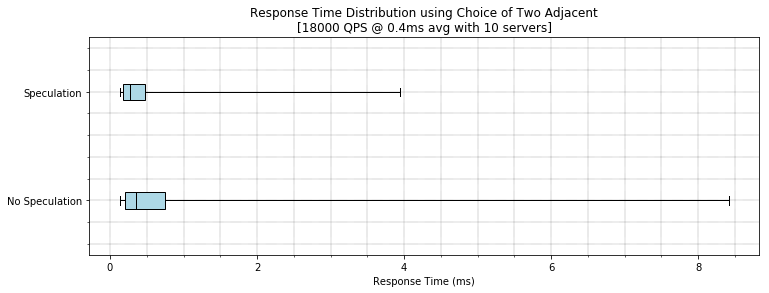

In [10]:
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.style as style

style.use('seaborn-pastel')

def color_bplot(bp, edge_color, fill_color):
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for box in bp['boxes']:
        box.set_facecolor(fill_color)
        
flier = dict(markerfacecolor='r', marker='.')
        
fig1, ax = plt.subplots(figsize=(12,4))

speculation_opts = {
    'No Speculation': sim,
    'Speculation': spec
}
opts = sorted(speculation_opts.keys())
data = [speculation_opts[i] for i in opts]

bplot1 = ax.boxplot(data, whis=[1,99],showfliers=False,flierprops=flier, labels=opts,
                    patch_artist=True, vert=False)
color_bplot(bplot1, 'black', 'lightblue')

plt.title("Response Time Distribution using Choice of Two Adjacent\n"
          "[{0} QPS @ {1}ms avg with {2} servers]".format(
    S_QPS, AVG_RESPONSE_MS, SERVERS)
)

plt.minorticks_on()
plt.grid(which='major', linestyle=':', linewidth='0.4', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.4', color='black')
plt.xlabel('Response Time (ms)')
plt.show()